In [116]:
import numpy as np
import pandas as pd
import pathlib
import scanpy as sc
import scvi
import seaborn as sns

In [79]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
SAMPLE_RAW_DATA_PATH = DATA_DIR / 'raw_data' / 'GSM5226574_C51ctr_raw_counts.csv.gz'

In [80]:
sample_data = sc.read_csv(SAMPLE_RAW_DATA_PATH).T
sample_data

AnnData object with n_obs × n_vars = 6099 × 34546

## Doublet removal

In [81]:
# Filter genes expressed in less than 10 cells
sc.pp.filter_genes(sample_data, min_cells=10)

In [82]:
# Keep only top 2000 highly variable genes
sc.pp.highly_variable_genes(sample_data, n_top_genes=2000, subset=True, flavor='seurat_v3')

In [83]:
scvi.model.SCVI.setup_anndata(sample_data)
model = scvi.model.SCVI(sample_data)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:28<00:00,  2.71it/s, v_num=1, train_loss_step=283, train_loss_epoch=323]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:28<00:00,  2.69it/s, v_num=1, train_loss_step=283, train_loss_epoch=323]


In [84]:
solo = scvi.external.SOLO.from_scvi_model(model, sample_data)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 211/400:  53%|█████▎    | 211/400 [00:53<00:48,  3.91it/s, v_num=1, train_loss_step=0.273, train_loss_epoch=0.285]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.287. Signaling Trainer to stop.


In [85]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1,0.016004,-0.816736,doublet
ATTCACTGTAACAGGC-1,0.932583,-1.565432,doublet
TAACTTCCAACCACGC-1,0.122472,-0.324930,doublet
TTGGGTACACGACAAG-1,-0.091546,-0.871438,doublet
AGGCCACAGAGTCACG-1,0.136089,-0.910898,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1,-1.386011,1.319305,singlet
CACTGGGGTCTACGTA-1,-2.570051,2.899939,singlet
CATACTTGTAGAGGAA-1,-2.375021,2.799108,singlet
TTTGGTTTCCACGGAC-1,-2.182600,1.873963,singlet


In [86]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1017,1017
singlet,5082,5082


In [87]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1,0.016004,-0.816736,doublet,0.832740
ATTCACTGTAACAGGC-1,0.932583,-1.565432,doublet,2.498016
TAACTTCCAACCACGC-1,0.122472,-0.324930,doublet,0.447401
TTGGGTACACGACAAG-1,-0.091546,-0.871438,doublet,0.779892
AGGCCACAGAGTCACG-1,0.136089,-0.910898,doublet,1.046986
...,...,...,...,...
CGCCATTGTTTGCCGG-1,-1.386011,1.319305,singlet,-2.705316
CACTGGGGTCTACGTA-1,-2.570051,2.899939,singlet,-5.469990
CATACTTGTAGAGGAA-1,-2.375021,2.799108,singlet,-5.174129
TTTGGTTTCCACGGAC-1,-2.182600,1.873963,singlet,-4.056564


/home/victor/anaconda3/envs/rna/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


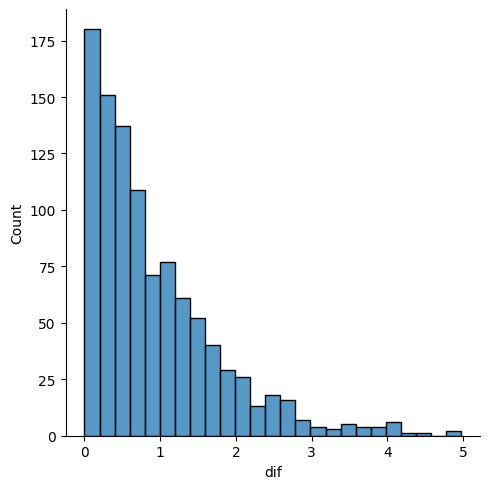

In [88]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [89]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif
ATTCACTGTAACAGGC-1,0.932583,-1.565432,doublet,2.498016
AGGCCACAGAGTCACG-1,0.136089,-0.910898,doublet,1.046986
CACTGAAGTCGAAGCA-1,1.453389,-1.922149,doublet,3.375538
ACTGATGTCTGCACCT-1,1.920868,-1.464083,doublet,3.384950
CCACGAGTCTCTTAAC-1,0.542825,-1.018460,doublet,1.561285
...,...,...,...,...
TGCGATACAGGACTAG-1,0.729539,-0.378849,doublet,1.108388
CAATACGCAATGTGGG-1,0.751478,-0.292480,doublet,1.043958
AAAGAACGTACACTCA-1,0.568477,-0.648536,doublet,1.217013
ATCAGGTGTCGTCTCT-1,0.706472,-0.713628,doublet,1.420100


In [94]:
sample_data = sc.read_csv(SAMPLE_RAW_DATA_PATH).T
sample_data

AnnData object with n_obs × n_vars = 6099 × 34546

In [95]:
sample_data.obs.index = sample_data.obs.index.map(lambda x: x[:-2])
sample_data.obs['doublet'] = sample_data.obs.index.isin(doublets.index)

In [96]:
sample_data.obs

,doublet
TAGGTACCATGGCCAC-1,False
ATTCACTGTAACAGGC-1,True
TAACTTCCAACCACGC-1,False
TTGGGTACACGACAAG-1,False
AGGCCACAGAGTCACG-1,True
...,...
CGCCATTGTTTGCCGG-1,False
CACTGGGGTCTACGTA-1,False
CATACTTGTAGAGGAA-1,False
TTTGGTTTCCACGGAC-1,False


In [97]:
sample_data = sample_data[~sample_data.obs.doublet]

In [98]:
sample_data

View of AnnData object with n_obs × n_vars = 5731 × 34546
    obs: 'doublet'

## Preprocessing

In [111]:
sample_data.var['mt'] = sample_data.var.index.str.startswith('MT-')

In [118]:
# Endpoint to retrieve the list of ribosomal genes was returning 404,
# so I manually copied the list from the tutorial
ribo_genes = ['FAU','MRPL13', 'RPL10', 'RPL10A','RPL10L', 'RPL11', 'RPL12', \
 'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A', \
 'RPL19', 'RPL21', 'RPL22', 'RPL22L1', 'RPL23', 'RPL23A', 'RPL24', \
 'RPL26', 'RPL26L1', 'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL3', \
 'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36', \
 'RPL36A', 'RPL36AL', 'RPL37', 'RPL37A', 'RPL38', 'RPL39','RPL3L', \
 'RPL4', 'RPL41', 'RPL5', 'RPL6', 'RPL7', 'RPL7A', 'RPL8', 'RPL9', \
 'RPLP0', 'RPLP1', 'RPLP2', 'RPS10', 'RPS11', 'RPS12', 'RPS13', \
 'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS2', \
 'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27', \
 'RPS27A', 'RPS27L', 'RPS28', 'RPS29', 'RPS3', 'RPS3A', 'RPS4X', \
 'RPS4Y1', 'RPS5', 'RPS6', 'RPS7', 'RPS8', 'RPS9', 'RPSA', 'RSL24D1', \
 'RPSL24D1P11', 'UBA52']

ribo_genes = np.array(ribo_genes)

88


In [119]:
sample_data.var['ribo'] = sample_data.var.index.isin(ribo_genes)

In [122]:
sample_data.var[sample_data.var.ribo == True]

,mt,ribo
RPL22,False,True
RPL11,False,True
RPS8,False,True
RPL5,False,True
RPS27,False,True
...,...,...
RPS4X,False,True
RPL36A,False,True
RPL39,False,True
RPL10,False,True


In [124]:
sc.pp.calculate_qc_metrics(sample_data, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [126]:
sample_data.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAGGTACCATGGCCAC-1,False,6764,24256.0,153.0,0.630772,55.0,0.226748
TAACTTCCAACCACGC-1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
TTGGGTACACGACAAG-1,False,4900,15220.0,3.0,0.019711,5.0,0.032852
TTACCGCCACTCAGAT-1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TTGGTTTTCCTAGCTC-1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1,False,299,405.0,0.0,0.000000,2.0,0.493827
